In [4]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score
%matplotlib inline
from matplotlib import pyplot as plt
from keras.models import model_from_json
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator as IDG
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.applications.xception import Xception
import os
import tensorflow as tf

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf.config.list_physical_devices('GPU')

[]

In [6]:
MODEL_NAMES = ['xception', 'dn121', 'vgg16', 'res152']

In [7]:
PATHS_H5 = {
    'xception' : 'ensembledata/xception-weights.h5',
    'dn121'    : 'ensembledata/DenseNet121_complete.h5',
    'vgg16'    : 'ensembledata/VGG16_complete.h5',
    'res152'   : 'ensembledata/ResNet152V2_complete.h5'
}

In [8]:
PREPROCESS_INPUTS = {
    'xception' : None,
    'dn121'    : None,
    'vgg16'    : None,
    'res152'   : None
}

In [9]:
MODELS = {
    'xception' : None,
    'dn121'    : None,
    'vgg16'    : None,
    'res152'   : None
}

# PREDICTIONS = {
#     'xception' : None,
#     'dn121'    : None,
#     'vgg16'    : None,
#     'res152'   : None
# }
PREDICTIONS = []

Y_HAT = {
    'xception' : None,
    'dn121'    : None,
    'vgg16'    : None,
    'res152'   : None
}

THRESHOLDS = {
    'xception' : None,
    'dn121'    : None,
    'vgg16'    : None,
    'res152'   : None
}

In [10]:
def build_models():
  for model_name in MODEL_NAMES: 
#       json_file = open(PATHS_ARCH[model_name], 'r')
#       model_architecture = json_file.read()
#       json_file.close()
#       model = model_from_json(model_architecture)
#       model.load_weights(PATHS_WEIGHTS[model_name])
#       MODELS[model_name] = model
      print(model_name)
      model = load_model(PATHS_H5[model_name], compile=False)
      MODELS[model_name] = model

In [11]:
def get_probabilities(raw_img):
  predictions = {
    'xception' : None,
    'dn121'    : None,
    'vgg16'    : None,
    'res152'   : None
}
  for model_name in MODEL_NAMES: 
    img = preprocess(raw_img, preproc_func = PREPROCESS_INPUTS[model_name])
    model = MODELS[model_name]
    predictions[model_name] = model.predict(img)[0]
  return predictions

In [12]:
def preprocess(raw_img, preproc_func = None):
    img = cv2.resize(raw_img, (224, 224))
    if preproc_func != None:
        img = preproc_func(img)
    else: 
        img = img/255.
        img = img.reshape(1, 224, 224, 3)
    return img

In [18]:
CLASSES = [ 
  'Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Pleural Effusion'
]
N_CLASSES = len(CLASSES)
df_val = pd.read_csv('CheXpert-v1.0-small/valid.csv')
# df_val = pd.read_csv('CheXpert-v1.0-small/valid.csv')
df_val = df_val[[
  'Path', 
  'No Finding',
  'Atelectasis',
  'Cardiomegaly',
  'Consolidation',
  'Edema',
  'Pleural Effusion'
]]
y_true = df_val[CLASSES].to_numpy()

def clean_df(df):
  # Focusing only on 5 classes:
  df = df[[
    'Path', 
    'Atelectasis',
    'Cardiomegaly',
    'Consolidation',
    'Edema',
    'Pleural Effusion'
  ]]

  # Handling the NaN values
  df = df.fillna(0)

  # Handling the uncertain values
  ## Different policy for each feature:
  u_ones = ['Atelectasis', 'Edema']
  u_zeros = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
  df[u_ones]  = df[u_ones].replace(-1, 1)
  df[u_zeros] = df[u_zeros].replace(-1, 0)
  print(df.shape)
  return df
df_val = clean_df(df_val)


In [19]:
build_models()

xception
dn121
vgg16
res152


In [20]:
preds = []
for filename in tqdm(df_val.Path):
    filename = filename
    print(filename)
    raw_img = cv2.imread(filename)
    preds.append(get_probabilities(raw_img))

for model_name in MODEL_NAMES:
    # PREDICTIONS[model_name] = np.array([p[model_name] for p in preds])[:, 1:]
    PREDICTIONS.append([p[model_name] for p in preds][:, 1:])

  0%|          | 0/234 [00:00<?, ?it/s]

CheXpert-v1.0-small/valid/patient64541/study1/view1_frontal.jpg
1/1 [==============================] - 3s 3s/step


  0%|          | 1/234 [00:05<22:11,  5.71s/it]

CheXpert-v1.0-small/valid/patient64542/study1/view1_frontal.jpg
1/1 [==============================] - 0s 203ms/step


  1%|          | 2/234 [00:06<10:36,  2.74s/it]

CheXpert-v1.0-small/valid/patient64542/study1/view2_lateral.jpg
1/1 [==============================] - 0s 202ms/step


  1%|▏         | 3/234 [00:07<06:57,  1.81s/it]

CheXpert-v1.0-small/valid/patient64543/study1/view1_frontal.jpg
1/1 [==============================] - 0s 205ms/step


  2%|▏         | 4/234 [00:07<05:12,  1.36s/it]

CheXpert-v1.0-small/valid/patient64544/study1/view1_frontal.jpg
1/1 [==============================] - 0s 208ms/step


  2%|▏         | 5/234 [00:08<04:16,  1.12s/it]

CheXpert-v1.0-small/valid/patient64545/study1/view1_frontal.jpg
1/1 [==============================] - 0s 199ms/step


  3%|▎         | 6/234 [00:09<03:40,  1.03it/s]

CheXpert-v1.0-small/valid/patient64546/study1/view1_frontal.jpg
1/1 [==============================] - 0s 213ms/step


  3%|▎         | 7/234 [00:09<03:17,  1.15it/s]

CheXpert-v1.0-small/valid/patient64547/study1/view1_frontal.jpg
1/1 [==============================] - 0s 203ms/step


  3%|▎         | 8/234 [00:10<03:03,  1.23it/s]

CheXpert-v1.0-small/valid/patient64547/study1/view2_frontal.jpg
1/1 [==============================] - 0s 204ms/step


  4%|▍         | 9/234 [00:11<02:53,  1.29it/s]

CheXpert-v1.0-small/valid/patient64547/study1/view3_lateral.jpg
1/1 [==============================] - 0s 210ms/step


  4%|▍         | 10/234 [00:11<02:46,  1.35it/s]

CheXpert-v1.0-small/valid/patient64548/study1/view1_frontal.jpg
1/1 [==============================] - 0s 205ms/step


  5%|▍         | 11/234 [00:12<02:41,  1.38it/s]

CheXpert-v1.0-small/valid/patient64549/study1/view1_frontal.jpg
1/1 [==============================] - 0s 193ms/step


  5%|▌         | 12/234 [00:13<02:36,  1.42it/s]

CheXpert-v1.0-small/valid/patient64550/study1/view1_frontal.jpg
1/1 [==============================] - 0s 213ms/step


  6%|▌         | 13/234 [00:13<02:34,  1.43it/s]

CheXpert-v1.0-small/valid/patient64551/study1/view1_frontal.jpg
1/1 [==============================] - 0s 176ms/step


  6%|▌         | 14/234 [00:14<02:29,  1.47it/s]

CheXpert-v1.0-small/valid/patient64551/study1/view2_lateral.jpg
1/1 [==============================] - 0s 181ms/step


  6%|▋         | 15/234 [00:15<02:25,  1.50it/s]

CheXpert-v1.0-small/valid/patient64552/study1/view1_frontal.jpg
1/1 [==============================] - 0s 194ms/step


  7%|▋         | 16/234 [00:15<02:22,  1.53it/s]

CheXpert-v1.0-small/valid/patient64553/study1/view1_frontal.jpg
1/1 [==============================] - 0s 220ms/step


  7%|▋         | 17/234 [00:16<02:24,  1.50it/s]

CheXpert-v1.0-small/valid/patient64554/study1/view1_frontal.jpg
1/1 [==============================] - 0s 217ms/step


  8%|▊         | 18/234 [00:17<02:26,  1.47it/s]

CheXpert-v1.0-small/valid/patient64555/study1/view1_frontal.jpg
1/1 [==============================] - 0s 211ms/step


  8%|▊         | 19/234 [00:17<02:27,  1.46it/s]

CheXpert-v1.0-small/valid/patient64556/study1/view1_frontal.jpg
1/1 [==============================] - 0s 223ms/step


  9%|▊         | 20/234 [00:18<02:29,  1.43it/s]

CheXpert-v1.0-small/valid/patient64556/study1/view2_lateral.jpg
1/1 [==============================] - 0s 213ms/step


  9%|▉         | 21/234 [00:19<02:30,  1.42it/s]

CheXpert-v1.0-small/valid/patient64557/study1/view1_frontal.jpg
1/1 [==============================] - 0s 199ms/step


  9%|▉         | 22/234 [00:19<02:27,  1.43it/s]

CheXpert-v1.0-small/valid/patient64558/study1/view1_frontal.jpg
1/1 [==============================] - 0s 210ms/step


 10%|▉         | 23/234 [00:20<02:26,  1.44it/s]

CheXpert-v1.0-small/valid/patient64558/study1/view2_lateral.jpg
1/1 [==============================] - 0s 203ms/step


 10%|█         | 24/234 [00:21<02:25,  1.45it/s]

CheXpert-v1.0-small/valid/patient64559/study1/view1_frontal.jpg
1/1 [==============================] - 0s 199ms/step


 11%|█         | 25/234 [00:22<02:22,  1.47it/s]

CheXpert-v1.0-small/valid/patient64559/study1/view2_lateral.jpg
1/1 [==============================] - 0s 193ms/step


 11%|█         | 26/234 [00:22<02:19,  1.49it/s]

CheXpert-v1.0-small/valid/patient64560/study1/view1_frontal.jpg
1/1 [==============================] - 0s 204ms/step


 12%|█▏        | 27/234 [00:23<02:19,  1.48it/s]

CheXpert-v1.0-small/valid/patient64560/study1/view2_lateral.jpg
1/1 [==============================] - 0s 207ms/step


 12%|█▏        | 28/234 [00:24<02:20,  1.47it/s]

CheXpert-v1.0-small/valid/patient64561/study1/view1_frontal.jpg
1/1 [==============================] - 0s 200ms/step


 12%|█▏        | 29/234 [00:24<02:18,  1.48it/s]

CheXpert-v1.0-small/valid/patient64562/study1/view1_frontal.jpg
1/1 [==============================] - 0s 189ms/step


 13%|█▎        | 30/234 [00:25<02:16,  1.49it/s]

CheXpert-v1.0-small/valid/patient64563/study1/view1_frontal.jpg
1/1 [==============================] - 0s 195ms/step


 13%|█▎        | 31/234 [00:26<02:15,  1.50it/s]

CheXpert-v1.0-small/valid/patient64564/study1/view1_frontal.jpg
1/1 [==============================] - 0s 203ms/step


 14%|█▎        | 32/234 [00:26<02:15,  1.49it/s]

CheXpert-v1.0-small/valid/patient64565/study1/view1_frontal.jpg
1/1 [==============================] - 0s 197ms/step


 14%|█▍        | 33/234 [00:27<02:14,  1.49it/s]

CheXpert-v1.0-small/valid/patient64566/study1/view1_frontal.jpg
1/1 [==============================] - 0s 206ms/step


 15%|█▍        | 34/234 [00:28<02:14,  1.49it/s]

CheXpert-v1.0-small/valid/patient64566/study1/view2_lateral.jpg
1/1 [==============================] - 0s 205ms/step


 15%|█▍        | 35/234 [00:28<02:14,  1.48it/s]

CheXpert-v1.0-small/valid/patient64567/study1/view1_frontal.jpg
1/1 [==============================] - 0s 211ms/step


 15%|█▌        | 36/234 [00:29<02:16,  1.45it/s]

CheXpert-v1.0-small/valid/patient64567/study1/view2_lateral.jpg
1/1 [==============================] - 0s 196ms/step


 16%|█▌        | 37/234 [00:30<02:17,  1.44it/s]

CheXpert-v1.0-small/valid/patient64568/study1/view1_frontal.jpg
1/1 [==============================] - 0s 211ms/step


 16%|█▌        | 38/234 [00:30<02:16,  1.43it/s]

CheXpert-v1.0-small/valid/patient64569/study1/view1_frontal.jpg
1/1 [==============================] - 0s 218ms/step


 17%|█▋        | 39/234 [00:31<02:17,  1.42it/s]

CheXpert-v1.0-small/valid/patient64570/study1/view1_frontal.jpg
1/1 [==============================] - 0s 231ms/step


 17%|█▋        | 40/234 [00:32<02:20,  1.38it/s]

CheXpert-v1.0-small/valid/patient64570/study1/view2_lateral.jpg
1/1 [==============================] - 0s 197ms/step


 18%|█▊        | 41/234 [00:33<02:18,  1.39it/s]

CheXpert-v1.0-small/valid/patient64571/study1/view1_frontal.jpg
1/1 [==============================] - 0s 197ms/step


 18%|█▊        | 42/234 [00:33<02:14,  1.43it/s]

CheXpert-v1.0-small/valid/patient64572/study1/view1_frontal.jpg
1/1 [==============================] - 0s 211ms/step


 18%|█▊        | 43/234 [00:34<02:12,  1.44it/s]

CheXpert-v1.0-small/valid/patient64573/study1/view1_frontal.jpg
1/1 [==============================] - 0s 201ms/step


 19%|█▉        | 44/234 [00:35<02:12,  1.43it/s]

CheXpert-v1.0-small/valid/patient64574/study1/view1_frontal.jpg
1/1 [==============================] - 0s 194ms/step


 19%|█▉        | 45/234 [00:35<02:10,  1.45it/s]

CheXpert-v1.0-small/valid/patient64575/study1/view1_frontal.jpg
1/1 [==============================] - 0s 204ms/step


 20%|█▉        | 46/234 [00:36<02:08,  1.46it/s]

CheXpert-v1.0-small/valid/patient64575/study1/view2_lateral.jpg
1/1 [==============================] - 0s 225ms/step


 20%|██        | 47/234 [00:37<02:10,  1.43it/s]

CheXpert-v1.0-small/valid/patient64576/study1/view1_frontal.jpg
1/1 [==============================] - 0s 232ms/step


 21%|██        | 48/234 [00:37<02:12,  1.41it/s]

CheXpert-v1.0-small/valid/patient64577/study1/view1_frontal.jpg
1/1 [==============================] - 0s 207ms/step


 21%|██        | 49/234 [00:38<02:10,  1.42it/s]

CheXpert-v1.0-small/valid/patient64578/study1/view1_frontal.jpg
1/1 [==============================] - 0s 198ms/step


 21%|██▏       | 50/234 [00:39<02:07,  1.45it/s]

CheXpert-v1.0-small/valid/patient64579/study1/view1_frontal.jpg
1/1 [==============================] - 0s 235ms/step


 22%|██▏       | 51/234 [00:40<02:12,  1.38it/s]

CheXpert-v1.0-small/valid/patient64580/study1/view1_frontal.jpg
1/1 [==============================] - 0s 203ms/step


 22%|██▏       | 52/234 [00:40<02:12,  1.38it/s]

CheXpert-v1.0-small/valid/patient64581/study1/view1_frontal.jpg
1/1 [==============================] - 0s 240ms/step


 23%|██▎       | 53/234 [00:41<02:14,  1.34it/s]

CheXpert-v1.0-small/valid/patient64581/study1/view3_lateral.jpg
1/1 [==============================] - 0s 195ms/step


 23%|██▎       | 54/234 [00:42<02:10,  1.37it/s]

CheXpert-v1.0-small/valid/patient64581/study1/view2_frontal.jpg
1/1 [==============================] - 0s 201ms/step


 24%|██▎       | 55/234 [00:42<02:07,  1.40it/s]

CheXpert-v1.0-small/valid/patient64582/study1/view1_frontal.jpg
1/1 [==============================] - 0s 196ms/step


 24%|██▍       | 56/234 [00:43<02:04,  1.42it/s]

CheXpert-v1.0-small/valid/patient64583/study1/view1_frontal.jpg
1/1 [==============================] - 0s 246ms/step


 24%|██▍       | 57/234 [00:44<02:37,  1.12it/s]

CheXpert-v1.0-small/valid/patient64584/study1/view1_frontal.jpg
1/1 [==============================] - 0s 237ms/step


 25%|██▍       | 58/234 [00:45<02:28,  1.19it/s]

CheXpert-v1.0-small/valid/patient64584/study1/view2_lateral.jpg
1/1 [==============================] - 0s 232ms/step


 25%|██▌       | 59/234 [00:46<02:23,  1.22it/s]

CheXpert-v1.0-small/valid/patient64585/study1/view1_frontal.jpg
1/1 [==============================] - 0s 223ms/step


 26%|██▌       | 60/234 [00:47<02:17,  1.26it/s]

CheXpert-v1.0-small/valid/patient64586/study1/view1_frontal.jpg
1/1 [==============================] - 0s 237ms/step


 26%|██▌       | 61/234 [00:47<02:13,  1.29it/s]

CheXpert-v1.0-small/valid/patient64587/study1/view1_frontal.jpg
1/1 [==============================] - 0s 232ms/step


 26%|██▋       | 62/234 [00:48<02:11,  1.31it/s]

CheXpert-v1.0-small/valid/patient64588/study1/view1_frontal.jpg
1/1 [==============================] - 0s 232ms/step


 27%|██▋       | 63/234 [00:49<02:08,  1.33it/s]

CheXpert-v1.0-small/valid/patient64588/study1/view2_lateral.jpg
1/1 [==============================] - 0s 219ms/step


 27%|██▋       | 64/234 [00:50<02:06,  1.34it/s]

CheXpert-v1.0-small/valid/patient64589/study1/view2_lateral.jpg
1/1 [==============================] - 0s 242ms/step


 28%|██▊       | 65/234 [00:50<02:05,  1.35it/s]

CheXpert-v1.0-small/valid/patient64589/study1/view1_frontal.jpg
1/1 [==============================] - 0s 226ms/step


 28%|██▊       | 66/234 [00:51<02:03,  1.36it/s]

CheXpert-v1.0-small/valid/patient64590/study1/view1_frontal.jpg
1/1 [==============================] - 0s 262ms/step


 29%|██▊       | 67/234 [00:52<02:07,  1.31it/s]

CheXpert-v1.0-small/valid/patient64590/study1/view2_lateral.jpg
1/1 [==============================] - 0s 262ms/step


 29%|██▉       | 68/234 [00:53<02:10,  1.27it/s]

CheXpert-v1.0-small/valid/patient64591/study1/view1_frontal.jpg
1/1 [==============================] - 0s 282ms/step


 29%|██▉       | 69/234 [00:54<02:12,  1.25it/s]

CheXpert-v1.0-small/valid/patient64592/study1/view1_frontal.jpg
1/1 [==============================] - 0s 251ms/step


 30%|██▉       | 70/234 [00:54<02:10,  1.26it/s]

CheXpert-v1.0-small/valid/patient64593/study1/view1_frontal.jpg
1/1 [==============================] - 0s 257ms/step


 30%|███       | 71/234 [00:55<02:08,  1.27it/s]

CheXpert-v1.0-small/valid/patient64594/study1/view1_frontal.jpg
1/1 [==============================] - 0s 228ms/step


 31%|███       | 72/234 [00:56<02:07,  1.28it/s]

CheXpert-v1.0-small/valid/patient64594/study1/view2_lateral.jpg
1/1 [==============================] - 0s 233ms/step


 31%|███       | 73/234 [00:57<02:04,  1.29it/s]

CheXpert-v1.0-small/valid/patient64595/study1/view1_frontal.jpg
1/1 [==============================] - 0s 248ms/step


 32%|███▏      | 74/234 [00:57<02:02,  1.30it/s]

CheXpert-v1.0-small/valid/patient64595/study1/view2_lateral.jpg
1/1 [==============================] - 0s 239ms/step


 32%|███▏      | 75/234 [00:58<02:00,  1.32it/s]

CheXpert-v1.0-small/valid/patient64596/study1/view1_frontal.jpg
1/1 [==============================] - 0s 232ms/step


 32%|███▏      | 76/234 [00:59<01:58,  1.33it/s]

CheXpert-v1.0-small/valid/patient64597/study1/view1_frontal.jpg
1/1 [==============================] - 0s 254ms/step


 33%|███▎      | 77/234 [01:00<01:58,  1.33it/s]

CheXpert-v1.0-small/valid/patient64597/study1/view2_lateral.jpg
1/1 [==============================] - 0s 253ms/step


 33%|███▎      | 78/234 [01:00<02:02,  1.27it/s]

CheXpert-v1.0-small/valid/patient64598/study1/view1_frontal.jpg
1/1 [==============================] - 0s 232ms/step


 34%|███▍      | 79/234 [01:01<01:59,  1.30it/s]

CheXpert-v1.0-small/valid/patient64599/study1/view1_frontal.jpg
1/1 [==============================] - 0s 246ms/step


 34%|███▍      | 80/234 [01:02<01:58,  1.30it/s]

CheXpert-v1.0-small/valid/patient64599/study1/view2_lateral.jpg
1/1 [==============================] - 0s 241ms/step


 35%|███▍      | 81/234 [01:03<01:57,  1.30it/s]

CheXpert-v1.0-small/valid/patient64600/study1/view1_frontal.jpg
1/1 [==============================] - 0s 234ms/step


 35%|███▌      | 82/234 [01:04<01:56,  1.31it/s]

CheXpert-v1.0-small/valid/patient64600/study1/view2_lateral.jpg
1/1 [==============================] - 0s 272ms/step


 35%|███▌      | 83/234 [01:04<01:56,  1.30it/s]

CheXpert-v1.0-small/valid/patient64601/study1/view1_frontal.jpg
1/1 [==============================] - 0s 234ms/step


 36%|███▌      | 84/234 [01:05<01:56,  1.29it/s]

CheXpert-v1.0-small/valid/patient64602/study1/view1_frontal.jpg
1/1 [==============================] - 0s 235ms/step


 36%|███▋      | 85/234 [01:06<01:54,  1.30it/s]

CheXpert-v1.0-small/valid/patient64603/study1/view1_frontal.jpg
1/1 [==============================] - 0s 227ms/step


 37%|███▋      | 86/234 [01:07<01:52,  1.32it/s]

CheXpert-v1.0-small/valid/patient64604/study1/view1_frontal.jpg
1/1 [==============================] - 0s 240ms/step


 37%|███▋      | 87/234 [01:07<01:49,  1.34it/s]

CheXpert-v1.0-small/valid/patient64605/study1/view1_frontal.jpg
1/1 [==============================] - 0s 229ms/step


 38%|███▊      | 88/234 [01:08<01:48,  1.35it/s]

CheXpert-v1.0-small/valid/patient64606/study1/view1_frontal.jpg
1/1 [==============================] - 0s 233ms/step


 38%|███▊      | 89/234 [01:09<01:47,  1.35it/s]

CheXpert-v1.0-small/valid/patient64606/study1/view2_lateral.jpg
1/1 [==============================] - 0s 230ms/step


 38%|███▊      | 90/234 [01:10<01:47,  1.34it/s]

CheXpert-v1.0-small/valid/patient64607/study1/view1_frontal.jpg
1/1 [==============================] - 0s 244ms/step


 39%|███▉      | 91/234 [01:10<01:47,  1.33it/s]

CheXpert-v1.0-small/valid/patient64608/study1/view1_frontal.jpg
1/1 [==============================] - 0s 246ms/step


 39%|███▉      | 92/234 [01:11<01:46,  1.34it/s]

CheXpert-v1.0-small/valid/patient64608/study1/view2_lateral.jpg
1/1 [==============================] - 0s 236ms/step


 40%|███▉      | 93/234 [01:12<01:45,  1.34it/s]

CheXpert-v1.0-small/valid/patient64609/study1/view1_frontal.jpg
1/1 [==============================] - 0s 236ms/step


 40%|████      | 94/234 [01:13<01:44,  1.34it/s]

CheXpert-v1.0-small/valid/patient64610/study1/view1_frontal.jpg
1/1 [==============================] - 0s 239ms/step


 41%|████      | 95/234 [01:13<01:43,  1.34it/s]

CheXpert-v1.0-small/valid/patient64611/study1/view1_frontal.jpg
1/1 [==============================] - 0s 240ms/step


 41%|████      | 96/234 [01:14<01:43,  1.33it/s]

CheXpert-v1.0-small/valid/patient64612/study1/view1_frontal.jpg
1/1 [==============================] - 0s 242ms/step


 41%|████▏     | 97/234 [01:15<01:42,  1.34it/s]

CheXpert-v1.0-small/valid/patient64613/study1/view1_frontal.jpg
1/1 [==============================] - 0s 240ms/step


 42%|████▏     | 98/234 [01:15<01:41,  1.34it/s]

CheXpert-v1.0-small/valid/patient64613/study1/view2_lateral.jpg
1/1 [==============================] - 0s 236ms/step


 42%|████▏     | 99/234 [01:16<01:40,  1.34it/s]

CheXpert-v1.0-small/valid/patient64614/study1/view1_frontal.jpg
1/1 [==============================] - 0s 232ms/step


 43%|████▎     | 100/234 [01:17<01:39,  1.35it/s]

CheXpert-v1.0-small/valid/patient64615/study1/view1_frontal.jpg
1/1 [==============================] - 0s 236ms/step


 43%|████▎     | 101/234 [01:18<01:38,  1.35it/s]

CheXpert-v1.0-small/valid/patient64615/study1/view2_lateral.jpg
1/1 [==============================] - 0s 257ms/step


 44%|████▎     | 102/234 [01:18<01:38,  1.34it/s]

CheXpert-v1.0-small/valid/patient64616/study1/view1_frontal.jpg
1/1 [==============================] - 0s 244ms/step


 44%|████▍     | 103/234 [01:19<01:37,  1.35it/s]

CheXpert-v1.0-small/valid/patient64616/study1/view2_lateral.jpg
1/1 [==============================] - 0s 230ms/step


 44%|████▍     | 104/234 [01:20<01:36,  1.34it/s]

CheXpert-v1.0-small/valid/patient64616/study1/view3_lateral.jpg
1/1 [==============================] - 0s 246ms/step


 45%|████▍     | 105/234 [01:21<01:36,  1.34it/s]

CheXpert-v1.0-small/valid/patient64617/study1/view1_frontal.jpg
1/1 [==============================] - 0s 252ms/step


 45%|████▌     | 106/234 [01:21<01:35,  1.34it/s]

CheXpert-v1.0-small/valid/patient64618/study1/view1_frontal.jpg
1/1 [==============================] - 0s 238ms/step


 46%|████▌     | 107/234 [01:22<01:33,  1.35it/s]

CheXpert-v1.0-small/valid/patient64618/study1/view2_lateral.jpg
1/1 [==============================] - 0s 245ms/step


 46%|████▌     | 108/234 [01:23<01:33,  1.34it/s]

CheXpert-v1.0-small/valid/patient64619/study1/view1_frontal.jpg
1/1 [==============================] - 0s 244ms/step


 47%|████▋     | 109/234 [01:24<01:33,  1.34it/s]

CheXpert-v1.0-small/valid/patient64620/study1/view1_frontal.jpg
1/1 [==============================] - 0s 246ms/step


 47%|████▋     | 110/234 [01:24<01:33,  1.33it/s]

CheXpert-v1.0-small/valid/patient64621/study1/view1_frontal.jpg
1/1 [==============================] - 0s 242ms/step


 47%|████▋     | 111/234 [01:25<01:32,  1.34it/s]

CheXpert-v1.0-small/valid/patient64622/study1/view1_frontal.jpg
1/1 [==============================] - 0s 240ms/step


 48%|████▊     | 112/234 [01:26<01:31,  1.34it/s]

CheXpert-v1.0-small/valid/patient64623/study1/view1_frontal.jpg
1/1 [==============================] - 0s 243ms/step


 48%|████▊     | 113/234 [01:27<01:30,  1.33it/s]

CheXpert-v1.0-small/valid/patient64624/study1/view1_frontal.jpg
1/1 [==============================] - 0s 250ms/step


 49%|████▊     | 114/234 [01:27<01:30,  1.33it/s]

CheXpert-v1.0-small/valid/patient64625/study1/view1_frontal.jpg
1/1 [==============================] - 0s 239ms/step


 49%|████▉     | 115/234 [01:28<01:28,  1.34it/s]

CheXpert-v1.0-small/valid/patient64625/study1/view2_lateral.jpg
1/1 [==============================] - 0s 240ms/step


 50%|████▉     | 116/234 [01:29<01:28,  1.33it/s]

CheXpert-v1.0-small/valid/patient64626/study1/view1_frontal.jpg
1/1 [==============================] - 0s 238ms/step


 50%|█████     | 117/234 [01:30<01:28,  1.32it/s]

CheXpert-v1.0-small/valid/patient64627/study1/view1_frontal.jpg
1/1 [==============================] - 0s 250ms/step


 50%|█████     | 118/234 [01:30<01:28,  1.32it/s]

CheXpert-v1.0-small/valid/patient64628/study1/view1_frontal.jpg
1/1 [==============================] - 0s 250ms/step


 51%|█████     | 119/234 [01:31<01:27,  1.31it/s]

CheXpert-v1.0-small/valid/patient64629/study1/view1_frontal.jpg
1/1 [==============================] - 0s 248ms/step


 51%|█████▏    | 120/234 [01:32<01:26,  1.31it/s]

CheXpert-v1.0-small/valid/patient64630/study1/view1_frontal.jpg
1/1 [==============================] - 0s 251ms/step


 52%|█████▏    | 121/234 [01:33<01:26,  1.31it/s]

CheXpert-v1.0-small/valid/patient64631/study1/view1_frontal.jpg
1/1 [==============================] - 0s 253ms/step


 52%|█████▏    | 122/234 [01:34<01:25,  1.30it/s]

CheXpert-v1.0-small/valid/patient64632/study1/view1_frontal.jpg
1/1 [==============================] - 0s 259ms/step


 53%|█████▎    | 123/234 [01:34<01:25,  1.30it/s]

CheXpert-v1.0-small/valid/patient64633/study1/view1_frontal.jpg
1/1 [==============================] - 0s 260ms/step


 53%|█████▎    | 124/234 [01:35<01:24,  1.30it/s]

CheXpert-v1.0-small/valid/patient64634/study1/view1_frontal.jpg
1/1 [==============================] - 0s 269ms/step


 53%|█████▎    | 125/234 [01:36<01:25,  1.28it/s]

CheXpert-v1.0-small/valid/patient64635/study1/view1_frontal.jpg
1/1 [==============================] - 0s 274ms/step


 54%|█████▍    | 126/234 [01:37<01:25,  1.27it/s]

CheXpert-v1.0-small/valid/patient64636/study1/view1_frontal.jpg
1/1 [==============================] - 0s 260ms/step


 54%|█████▍    | 127/234 [01:38<01:24,  1.26it/s]

CheXpert-v1.0-small/valid/patient64637/study1/view1_frontal.jpg
1/1 [==============================] - 0s 273ms/step


 55%|█████▍    | 128/234 [01:38<01:24,  1.26it/s]

CheXpert-v1.0-small/valid/patient64638/study1/view1_frontal.jpg
1/1 [==============================] - 0s 267ms/step


 55%|█████▌    | 129/234 [01:39<01:23,  1.26it/s]

CheXpert-v1.0-small/valid/patient64639/study1/view1_frontal.jpg
1/1 [==============================] - 0s 273ms/step


 56%|█████▌    | 130/234 [01:40<01:22,  1.26it/s]

CheXpert-v1.0-small/valid/patient64640/study1/view2_lateral.jpg
1/1 [==============================] - 0s 273ms/step


 56%|█████▌    | 131/234 [01:41<01:21,  1.26it/s]

CheXpert-v1.0-small/valid/patient64640/study1/view1_frontal.jpg
1/1 [==============================] - 0s 274ms/step


 56%|█████▋    | 132/234 [01:41<01:21,  1.25it/s]

CheXpert-v1.0-small/valid/patient64641/study1/view1_frontal.jpg
1/1 [==============================] - 0s 270ms/step


 57%|█████▋    | 133/234 [01:42<01:20,  1.26it/s]

CheXpert-v1.0-small/valid/patient64642/study1/view1_frontal.jpg
1/1 [==============================] - 0s 261ms/step


 57%|█████▋    | 134/234 [01:43<01:19,  1.26it/s]

CheXpert-v1.0-small/valid/patient64643/study1/view1_frontal.jpg
1/1 [==============================] - 0s 271ms/step


 58%|█████▊    | 135/234 [01:44<01:19,  1.24it/s]

CheXpert-v1.0-small/valid/patient64644/study1/view1_frontal.jpg
1/1 [==============================] - 0s 284ms/step


 58%|█████▊    | 136/234 [01:45<01:19,  1.24it/s]

CheXpert-v1.0-small/valid/patient64645/study1/view1_frontal.jpg
1/1 [==============================] - 0s 284ms/step


 59%|█████▊    | 137/234 [01:46<01:19,  1.22it/s]

CheXpert-v1.0-small/valid/patient64646/study1/view1_frontal.jpg
1/1 [==============================] - 0s 304ms/step


 59%|█████▉    | 138/234 [01:46<01:19,  1.20it/s]

CheXpert-v1.0-small/valid/patient64647/study1/view1_frontal.jpg
1/1 [==============================] - 0s 314ms/step


 59%|█████▉    | 139/234 [01:47<01:22,  1.15it/s]

CheXpert-v1.0-small/valid/patient64648/study1/view1_frontal.jpg
1/1 [==============================] - 0s 296ms/step


 60%|█████▉    | 140/234 [01:48<01:21,  1.15it/s]

CheXpert-v1.0-small/valid/patient64649/study1/view1_frontal.jpg
1/1 [==============================] - 0s 309ms/step


 60%|██████    | 141/234 [01:49<01:21,  1.14it/s]

CheXpert-v1.0-small/valid/patient64650/study1/view1_frontal.jpg
1/1 [==============================] - 0s 299ms/step


 61%|██████    | 142/234 [01:50<01:21,  1.13it/s]

CheXpert-v1.0-small/valid/patient64651/study1/view1_frontal.jpg
1/1 [==============================] - 0s 305ms/step


 61%|██████    | 143/234 [01:51<01:20,  1.13it/s]

CheXpert-v1.0-small/valid/patient64652/study1/view1_frontal.jpg
1/1 [==============================] - 0s 303ms/step


 62%|██████▏   | 144/234 [01:52<01:19,  1.13it/s]

CheXpert-v1.0-small/valid/patient64653/study1/view1_frontal.jpg
1/1 [==============================] - 0s 301ms/step


 62%|██████▏   | 145/234 [01:53<01:18,  1.13it/s]

CheXpert-v1.0-small/valid/patient64654/study1/view1_frontal.jpg
1/1 [==============================] - 0s 313ms/step


 62%|██████▏   | 146/234 [01:54<01:18,  1.13it/s]

CheXpert-v1.0-small/valid/patient64655/study1/view1_frontal.jpg
1/1 [==============================] - 0s 323ms/step


 63%|██████▎   | 147/234 [01:55<01:18,  1.12it/s]

CheXpert-v1.0-small/valid/patient64656/study1/view1_frontal.jpg
1/1 [==============================] - 0s 320ms/step


 63%|██████▎   | 148/234 [01:55<01:17,  1.11it/s]

CheXpert-v1.0-small/valid/patient64657/study1/view1_frontal.jpg
1/1 [==============================] - 0s 317ms/step


 64%|██████▎   | 149/234 [01:56<01:16,  1.12it/s]

CheXpert-v1.0-small/valid/patient64658/study1/view1_frontal.jpg
1/1 [==============================] - 0s 306ms/step


 64%|██████▍   | 150/234 [01:57<01:15,  1.12it/s]

CheXpert-v1.0-small/valid/patient64659/study1/view1_frontal.jpg
1/1 [==============================] - 0s 314ms/step


 65%|██████▍   | 151/234 [01:58<01:14,  1.12it/s]

CheXpert-v1.0-small/valid/patient64660/study1/view1_frontal.jpg
1/1 [==============================] - 0s 312ms/step


 65%|██████▍   | 152/234 [01:59<01:13,  1.12it/s]

CheXpert-v1.0-small/valid/patient64661/study1/view1_frontal.jpg
1/1 [==============================] - 0s 306ms/step


 65%|██████▌   | 153/234 [02:00<01:12,  1.12it/s]

CheXpert-v1.0-small/valid/patient64662/study1/view1_frontal.jpg
1/1 [==============================] - 0s 328ms/step


 66%|██████▌   | 154/234 [02:01<01:12,  1.11it/s]

CheXpert-v1.0-small/valid/patient64663/study1/view1_frontal.jpg
1/1 [==============================] - 0s 323ms/step


 66%|██████▌   | 155/234 [02:02<01:11,  1.10it/s]

CheXpert-v1.0-small/valid/patient64664/study1/view1_frontal.jpg
1/1 [==============================] - 0s 320ms/step


 67%|██████▋   | 156/234 [02:03<01:11,  1.08it/s]

CheXpert-v1.0-small/valid/patient64665/study1/view1_frontal.jpg
1/1 [==============================] - 0s 316ms/step


 67%|██████▋   | 157/234 [02:04<01:11,  1.08it/s]

CheXpert-v1.0-small/valid/patient64666/study1/view1_frontal.jpg
1/1 [==============================] - 0s 353ms/step


 68%|██████▊   | 158/234 [02:05<01:11,  1.06it/s]

CheXpert-v1.0-small/valid/patient64667/study1/view1_frontal.jpg
1/1 [==============================] - 0s 329ms/step


 68%|██████▊   | 159/234 [02:06<01:10,  1.07it/s]

CheXpert-v1.0-small/valid/patient64668/study1/view1_frontal.jpg
1/1 [==============================] - 0s 309ms/step


 68%|██████▊   | 160/234 [02:06<01:08,  1.08it/s]

CheXpert-v1.0-small/valid/patient64669/study1/view1_frontal.jpg
1/1 [==============================] - 0s 330ms/step


 69%|██████▉   | 161/234 [02:07<01:07,  1.08it/s]

CheXpert-v1.0-small/valid/patient64670/study1/view1_frontal.jpg
1/1 [==============================] - 0s 309ms/step


 69%|██████▉   | 162/234 [02:08<01:05,  1.09it/s]

CheXpert-v1.0-small/valid/patient64671/study1/view1_frontal.jpg
1/1 [==============================] - 0s 309ms/step


 70%|██████▉   | 163/234 [02:09<01:04,  1.11it/s]

CheXpert-v1.0-small/valid/patient64672/study1/view1_frontal.jpg
1/1 [==============================] - 0s 317ms/step


 70%|███████   | 164/234 [02:10<01:03,  1.10it/s]

CheXpert-v1.0-small/valid/patient64673/study1/view1_frontal.jpg
1/1 [==============================] - 0s 320ms/step


 71%|███████   | 165/234 [02:11<01:02,  1.10it/s]

CheXpert-v1.0-small/valid/patient64674/study1/view1_frontal.jpg
1/1 [==============================] - 0s 328ms/step


 71%|███████   | 166/234 [02:12<01:02,  1.09it/s]

CheXpert-v1.0-small/valid/patient64675/study1/view1_frontal.jpg
1/1 [==============================] - 0s 332ms/step


 71%|███████▏  | 167/234 [02:13<01:01,  1.08it/s]

CheXpert-v1.0-small/valid/patient64676/study1/view1_frontal.jpg
1/1 [==============================] - 0s 329ms/step


 72%|███████▏  | 168/234 [02:14<01:01,  1.07it/s]

CheXpert-v1.0-small/valid/patient64676/study1/view2_lateral.jpg
1/1 [==============================] - 0s 331ms/step


 72%|███████▏  | 169/234 [02:15<01:00,  1.07it/s]

CheXpert-v1.0-small/valid/patient64677/study1/view1_frontal.jpg
1/1 [==============================] - 0s 333ms/step


 73%|███████▎  | 170/234 [02:16<01:00,  1.06it/s]

CheXpert-v1.0-small/valid/patient64678/study1/view1_frontal.jpg
1/1 [==============================] - 0s 342ms/step


 73%|███████▎  | 171/234 [02:17<00:59,  1.06it/s]

CheXpert-v1.0-small/valid/patient64679/study1/view1_frontal.jpg
1/1 [==============================] - 0s 358ms/step


 74%|███████▎  | 172/234 [02:18<00:59,  1.05it/s]

CheXpert-v1.0-small/valid/patient64680/study1/view1_frontal.jpg
1/1 [==============================] - 0s 343ms/step


 74%|███████▍  | 173/234 [02:19<00:58,  1.05it/s]

CheXpert-v1.0-small/valid/patient64681/study1/view1_frontal.jpg
1/1 [==============================] - 0s 339ms/step


 74%|███████▍  | 174/234 [02:20<00:57,  1.04it/s]

CheXpert-v1.0-small/valid/patient64682/study1/view1_frontal.jpg
1/1 [==============================] - 0s 368ms/step


 75%|███████▍  | 175/234 [02:21<00:57,  1.03it/s]

CheXpert-v1.0-small/valid/patient64683/study1/view1_frontal.jpg
1/1 [==============================] - 0s 343ms/step


 75%|███████▌  | 176/234 [02:21<00:56,  1.03it/s]

CheXpert-v1.0-small/valid/patient64684/study1/view1_frontal.jpg
1/1 [==============================] - 0s 342ms/step


 76%|███████▌  | 177/234 [02:22<00:54,  1.04it/s]

CheXpert-v1.0-small/valid/patient64685/study1/view1_frontal.jpg
1/1 [==============================] - 0s 336ms/step


 76%|███████▌  | 178/234 [02:23<00:53,  1.04it/s]

CheXpert-v1.0-small/valid/patient64686/study1/view1_frontal.jpg
1/1 [==============================] - 0s 341ms/step


 76%|███████▋  | 179/234 [02:24<00:52,  1.04it/s]

CheXpert-v1.0-small/valid/patient64687/study1/view1_frontal.jpg
1/1 [==============================] - 0s 349ms/step


 77%|███████▋  | 180/234 [02:25<00:51,  1.05it/s]

CheXpert-v1.0-small/valid/patient64688/study1/view1_frontal.jpg
1/1 [==============================] - 0s 335ms/step


 77%|███████▋  | 181/234 [02:26<00:50,  1.04it/s]

CheXpert-v1.0-small/valid/patient64689/study1/view1_frontal.jpg
1/1 [==============================] - 0s 348ms/step


 78%|███████▊  | 182/234 [02:27<00:49,  1.04it/s]

CheXpert-v1.0-small/valid/patient64690/study1/view1_frontal.jpg
1/1 [==============================] - 0s 337ms/step


 78%|███████▊  | 183/234 [02:28<00:48,  1.04it/s]

CheXpert-v1.0-small/valid/patient64691/study1/view1_frontal.jpg
1/1 [==============================] - 0s 347ms/step


 79%|███████▊  | 184/234 [02:29<00:48,  1.04it/s]

CheXpert-v1.0-small/valid/patient64692/study1/view1_frontal.jpg
1/1 [==============================] - 0s 346ms/step


 79%|███████▉  | 185/234 [02:30<00:47,  1.04it/s]

CheXpert-v1.0-small/valid/patient64693/study1/view1_frontal.jpg
1/1 [==============================] - 0s 354ms/step


 79%|███████▉  | 186/234 [02:31<00:46,  1.04it/s]

CheXpert-v1.0-small/valid/patient64694/study1/view1_frontal.jpg
1/1 [==============================] - 0s 338ms/step


 80%|███████▉  | 187/234 [02:32<00:44,  1.04it/s]

CheXpert-v1.0-small/valid/patient64695/study1/view1_frontal.jpg
1/1 [==============================] - 0s 345ms/step


 80%|████████  | 188/234 [02:33<00:43,  1.05it/s]

CheXpert-v1.0-small/valid/patient64696/study1/view1_frontal.jpg
1/1 [==============================] - 0s 345ms/step


 81%|████████  | 189/234 [02:34<00:43,  1.04it/s]

CheXpert-v1.0-small/valid/patient64697/study1/view1_frontal.jpg
1/1 [==============================] - 0s 342ms/step


 81%|████████  | 190/234 [02:35<00:42,  1.04it/s]

CheXpert-v1.0-small/valid/patient64698/study1/view1_frontal.jpg
1/1 [==============================] - 0s 347ms/step


 82%|████████▏ | 191/234 [02:36<00:41,  1.04it/s]

CheXpert-v1.0-small/valid/patient64699/study1/view1_frontal.jpg
1/1 [==============================] - 0s 346ms/step


 82%|████████▏ | 192/234 [02:37<00:40,  1.04it/s]

CheXpert-v1.0-small/valid/patient64700/study1/view1_frontal.jpg
1/1 [==============================] - 0s 358ms/step


 82%|████████▏ | 193/234 [02:38<00:40,  1.02it/s]

CheXpert-v1.0-small/valid/patient64701/study1/view1_frontal.jpg
1/1 [==============================] - 0s 351ms/step


 83%|████████▎ | 194/234 [02:39<00:39,  1.01it/s]

CheXpert-v1.0-small/valid/patient64702/study1/view1_frontal.jpg
1/1 [==============================] - 0s 354ms/step


 83%|████████▎ | 195/234 [02:40<00:38,  1.01it/s]

CheXpert-v1.0-small/valid/patient64703/study1/view1_frontal.jpg
1/1 [==============================] - 0s 354ms/step


 84%|████████▍ | 196/234 [02:41<00:37,  1.01it/s]

CheXpert-v1.0-small/valid/patient64704/study1/view1_frontal.jpg
1/1 [==============================] - 0s 373ms/step


 84%|████████▍ | 197/234 [02:42<00:37,  1.00s/it]

CheXpert-v1.0-small/valid/patient64705/study1/view1_frontal.jpg
1/1 [==============================] - 0s 363ms/step


 85%|████████▍ | 198/234 [02:43<00:35,  1.00it/s]

CheXpert-v1.0-small/valid/patient64705/study1/view2_lateral.jpg
1/1 [==============================] - 0s 358ms/step


 85%|████████▌ | 199/234 [02:44<00:34,  1.00it/s]

CheXpert-v1.0-small/valid/patient64706/study1/view1_frontal.jpg
1/1 [==============================] - 0s 361ms/step


 85%|████████▌ | 200/234 [02:45<00:33,  1.00it/s]

CheXpert-v1.0-small/valid/patient64707/study1/view1_frontal.jpg
1/1 [==============================] - 0s 372ms/step


 86%|████████▌ | 201/234 [02:46<00:33,  1.02s/it]

CheXpert-v1.0-small/valid/patient64708/study1/view1_frontal.jpg
1/1 [==============================] - 0s 353ms/step


 86%|████████▋ | 202/234 [02:47<00:32,  1.02s/it]

CheXpert-v1.0-small/valid/patient64709/study1/view1_frontal.jpg
1/1 [==============================] - 1s 596ms/step


 87%|████████▋ | 203/234 [02:48<00:35,  1.15s/it]

CheXpert-v1.0-small/valid/patient64710/study1/view1_frontal.jpg
1/1 [==============================] - 1s 612ms/step


 87%|████████▋ | 204/234 [02:50<00:37,  1.26s/it]

CheXpert-v1.0-small/valid/patient64711/study1/view1_frontal.jpg
1/1 [==============================] - 1s 567ms/step


 88%|████████▊ | 205/234 [02:51<00:38,  1.34s/it]

CheXpert-v1.0-small/valid/patient64712/study1/view1_frontal.jpg
1/1 [==============================] - 1s 520ms/step


 88%|████████▊ | 206/234 [02:53<00:38,  1.38s/it]

CheXpert-v1.0-small/valid/patient64713/study1/view1_frontal.jpg
1/1 [==============================] - 1s 587ms/step


 88%|████████▊ | 207/234 [02:54<00:38,  1.41s/it]

CheXpert-v1.0-small/valid/patient64714/study1/view1_frontal.jpg
1/1 [==============================] - 1s 553ms/step


 89%|████████▉ | 208/234 [02:56<00:37,  1.44s/it]

CheXpert-v1.0-small/valid/patient64715/study1/view1_frontal.jpg
1/1 [==============================] - 1s 532ms/step


 89%|████████▉ | 209/234 [02:57<00:35,  1.43s/it]

CheXpert-v1.0-small/valid/patient64716/study1/view1_frontal.jpg
1/1 [==============================] - 1s 525ms/step


 90%|████████▉ | 210/234 [02:59<00:34,  1.44s/it]

CheXpert-v1.0-small/valid/patient64717/study1/view1_frontal.jpg
1/1 [==============================] - 1s 571ms/step


 90%|█████████ | 211/234 [03:00<00:33,  1.45s/it]

CheXpert-v1.0-small/valid/patient64718/study1/view1_frontal.jpg
1/1 [==============================] - 1s 537ms/step


 91%|█████████ | 212/234 [03:02<00:31,  1.44s/it]

CheXpert-v1.0-small/valid/patient64719/study1/view1_frontal.jpg
1/1 [==============================] - 1s 556ms/step


 91%|█████████ | 213/234 [03:03<00:30,  1.44s/it]

CheXpert-v1.0-small/valid/patient64720/study1/view1_frontal.jpg
1/1 [==============================] - 1s 558ms/step


 91%|█████████▏| 214/234 [03:05<00:28,  1.44s/it]

CheXpert-v1.0-small/valid/patient64721/study1/view1_frontal.jpg
1/1 [==============================] - 1s 571ms/step


 92%|█████████▏| 215/234 [03:06<00:27,  1.44s/it]

CheXpert-v1.0-small/valid/patient64722/study1/view1_frontal.jpg
1/1 [==============================] - 1s 571ms/step


 92%|█████████▏| 216/234 [03:07<00:26,  1.45s/it]

CheXpert-v1.0-small/valid/patient64723/study1/view1_frontal.jpg
1/1 [==============================] - 1s 534ms/step


 93%|█████████▎| 217/234 [03:09<00:24,  1.45s/it]

CheXpert-v1.0-small/valid/patient64724/study1/view1_frontal.jpg
1/1 [==============================] - 1s 578ms/step


 93%|█████████▎| 218/234 [03:10<00:23,  1.45s/it]

CheXpert-v1.0-small/valid/patient64725/study1/view1_frontal.jpg
1/1 [==============================] - 1s 519ms/step


 94%|█████████▎| 219/234 [03:12<00:21,  1.44s/it]

CheXpert-v1.0-small/valid/patient64726/study1/view1_frontal.jpg
1/1 [==============================] - 1s 565ms/step


 94%|█████████▍| 220/234 [03:13<00:20,  1.44s/it]

CheXpert-v1.0-small/valid/patient64727/study1/view1_frontal.jpg
1/1 [==============================] - 1s 535ms/step


 94%|█████████▍| 221/234 [03:15<00:18,  1.44s/it]

CheXpert-v1.0-small/valid/patient64728/study1/view1_frontal.jpg
1/1 [==============================] - 1s 603ms/step


 95%|█████████▍| 222/234 [03:16<00:17,  1.45s/it]

CheXpert-v1.0-small/valid/patient64729/study1/view1_frontal.jpg
1/1 [==============================] - 1s 571ms/step


 95%|█████████▌| 223/234 [03:18<00:16,  1.46s/it]

CheXpert-v1.0-small/valid/patient64730/study1/view1_frontal.jpg
1/1 [==============================] - 1s 532ms/step


 96%|█████████▌| 224/234 [03:19<00:14,  1.48s/it]

CheXpert-v1.0-small/valid/patient64731/study1/view1_frontal.jpg
1/1 [==============================] - 1s 561ms/step


 96%|█████████▌| 225/234 [03:21<00:13,  1.50s/it]

CheXpert-v1.0-small/valid/patient64732/study1/view1_frontal.jpg
1/1 [==============================] - 1s 545ms/step


 97%|█████████▋| 226/234 [03:22<00:11,  1.48s/it]

CheXpert-v1.0-small/valid/patient64733/study1/view1_frontal.jpg
1/1 [==============================] - 1s 583ms/step


 97%|█████████▋| 227/234 [03:24<00:10,  1.48s/it]

CheXpert-v1.0-small/valid/patient64734/study1/view1_frontal.jpg
1/1 [==============================] - 1s 578ms/step


 97%|█████████▋| 228/234 [03:25<00:08,  1.48s/it]

CheXpert-v1.0-small/valid/patient64735/study1/view1_frontal.jpg
1/1 [==============================] - 1s 562ms/step


 98%|█████████▊| 229/234 [03:27<00:07,  1.47s/it]

CheXpert-v1.0-small/valid/patient64736/study1/view1_frontal.jpg
1/1 [==============================] - 1s 578ms/step


 98%|█████████▊| 230/234 [03:28<00:05,  1.47s/it]

CheXpert-v1.0-small/valid/patient64737/study1/view1_frontal.jpg
1/1 [==============================] - 1s 557ms/step


 99%|█████████▊| 231/234 [03:29<00:04,  1.47s/it]

CheXpert-v1.0-small/valid/patient64738/study1/view1_frontal.jpg
1/1 [==============================] - 1s 556ms/step


 99%|█████████▉| 232/234 [03:31<00:02,  1.47s/it]

CheXpert-v1.0-small/valid/patient64739/study1/view1_frontal.jpg
1/1 [==============================] - 1s 567ms/step


100%|█████████▉| 233/234 [03:32<00:01,  1.46s/it]

CheXpert-v1.0-small/valid/patient64740/study1/view1_frontal.jpg
1/1 [==============================] - 1s 570ms/step


100%|██████████| 234/234 [03:34<00:00,  1.09it/s]


In [13]:
AUCS = {
    'xception' : None,
    'dn121'    : None,
    'vgg16'    : None,
    'res152'   : None
}
def plot_roc(prediction, model_name):
  temp = []
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')

  for i in range(N_CLASSES):
    fpr, tpr, thresholds = roc_curve(y_true[:, i], prediction[:, i])
    individual_auc = auc(fpr, tpr)
    temp.append(individual_auc)
    plt.plot(fpr, tpr, label= (CLASSES[i] + '(area = {0:.3g})'.format(individual_auc)))

  AUCS[model_name] = temp

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve: {}'.format(model_name))
  plt.legend(loc='best')
  plt.show()

In [14]:
def get_opt_thresh(prediction):
  J_stats = [None]*N_CLASSES
  opt_thresholds = [None]*N_CLASSES
  for i in range(N_CLASSES):
    fpr, tpr, thresholds = roc_curve(y_true[:, i], prediction[:, i])
    J_stats[i] = tpr - fpr # sensitivity - (1 - specificity)
    opt_thresholds[i] = thresholds[np.argmax(J_stats[i])]
  return opt_thresholds

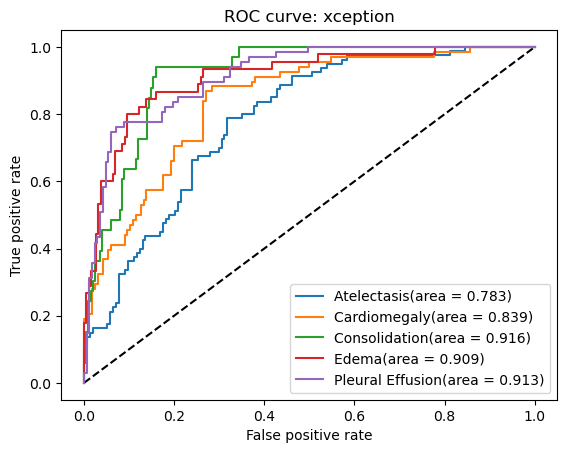

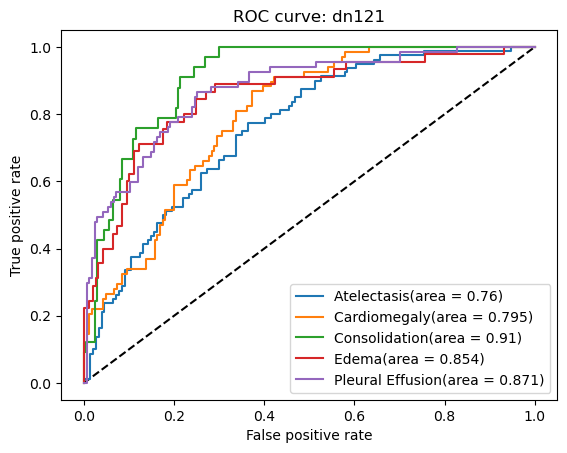

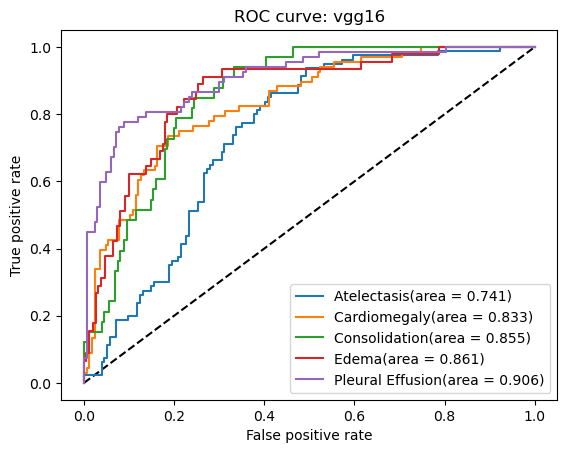

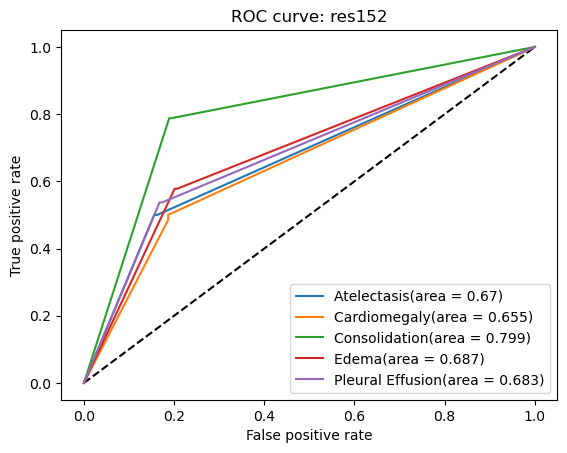

In [15]:
for model_name in MODEL_NAMES:
  plot_roc(PREDICTIONS[model_name], model_name)

In [16]:
for model_name in MODEL_NAMES:
  THRESHOLDS[model_name] = get_opt_thresh(PREDICTIONS[model_name])

In [17]:
def predict(preds, thresh):
  y_hat = np.zeros(preds.shape)
  for i in range(N_CLASSES):
    y_hat[:, i] = preds[:, i] >= thresh[i]
  return y_hat

In [18]:
for model_name in MODEL_NAMES:
  Y_HAT[model_name] = predict(PREDICTIONS[model_name], THRESHOLDS[model_name])

In [32]:
print(Y_HAT)

{'xception': array([[1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 1., 0., 0., 1.]]), 'dn121': array([[1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [1., 1., 1., 1., 1.]]), 'vgg16': array([[1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 1., 0.],
       [1., 1., 0., 1., 0.],
       [1., 1., 0., 1., 0.]]), 'res152': array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])}


In [33]:
for i in Y_HAT.keys():
    pd.DataFrame(Y_HAT[i]).to_csv("ylabels_" + i + ".csv")

In [34]:
print(y_true)
pd.DataFrame(y_true).to_csv("ylabels.csv")

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1.]]


In [19]:
for model_name in MODEL_NAMES:
  print("{} : F1-Score : {}".format(model_name, np.round(f1_score(y_true, Y_HAT[model_name], average=None), 3)))
  print("{} : Categorical Accuracy : {}".format(model_name, np.round(accuracy_score(y_true, Y_HAT[model_name]), 3)))

xception : F1-Score : [0.656 0.686 0.646 0.684 0.785]
xception : Categorical Accuracy : 0.423
dn121 : F1-Score : [0.626 0.624 0.524 0.571 0.695]
dn121 : Categorical Accuracy : 0.312
vgg16 : F1-Score : [0.648 0.671 0.473 0.603 0.776]
vgg16 : Categorical Accuracy : 0.338
res152 : F1-Score : [0.556 0.511 0.536 0.477 0.55 ]
res152 : Categorical Accuracy : 0.402


## Ensemble :

In [37]:
WEIGHTS = {
    'xception' : [0.50, 0.30, 1.00, 1.10, 1.00],
    'dn121'    : [1.50, 0.20, 1.00, 0.10, 0.40],
    'vgg16'    : [0.80, 0.50, 0.90, 0.00, 0.75],
    'res152'   : [0.80, 0.50, 0.90, 0.00, 0.75]
}
factor=1.0/np.sum(np.array(list(WEIGHTS.values())), axis=0)
normalized_W = {k: v*factor for k, v in WEIGHTS.items() }

for model_name in MODEL_NAMES:
  print(np.round(AUCS[model_name], 3))

[0.783 0.839 0.916 0.909 0.913]
[0.76  0.795 0.91  0.854 0.871]
[0.741 0.833 0.855 0.861 0.906]
[0.67  0.655 0.799 0.687 0.683]


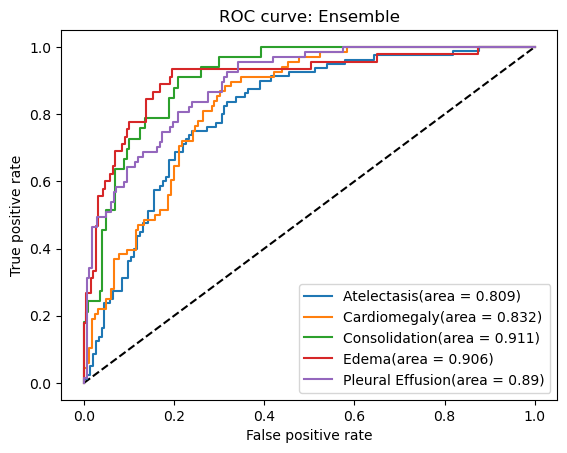

Model: xception | Avg AUC: 0.872
Model: dn121 | Avg AUC: 0.838
Model: vgg16 | Avg AUC: 0.839
Model: res152 | Avg AUC: 0.699
Ensemble | Avg AUC: 0.870

Thresholds: [0.08635 0.01324 0.03021 0.03026 0.03863]
F1-Score  : [0.684 0.667 0.571 0.677 0.681]
Categorical Accuracy : 0.38



In [43]:
"""Ensembling the models"""

sum = 0
for model_name in MODEL_NAMES:
  sum += PREDICTIONS[model_name] * normalized_W[model_name]
ensembled_predictions = sum/len(MODEL_NAMES)

plot_roc(ensembled_predictions, 'Ensemble')
thresh = get_opt_thresh(ensembled_predictions)
y_hat = predict(ensembled_predictions, thresh)
f1 = f1_score(y_true, y_hat, average=None)
catacc = accuracy_score(y_true, y_hat)

for model_name in MODEL_NAMES:
  avg_auc = np.round(np.mean(AUCS[model_name]), 3)
  print("Model: {} | Avg AUC: {}".format(model_name, avg_auc))

print("Ensemble | Avg AUC: {0:0.3f}".format(np.mean(AUCS['Ensemble'])))

print("""
Thresholds: {}
F1-Score  : {}
Categorical Accuracy : {}
""".format(np.round(thresh, 5), np.round(f1, 3), np.round(catacc, 3)))